# Data access

## when working on Margaret:
I got the data from Anna & Tancredi. The spatial file is 6w tumor slide, spatial in-house method processed with spacemake. The other data is annotated single-nuclei data, exported by Anna. Method details - idk.

The data is located in Anna's home directory on the lab server:
`/data/local/rajewsky/home/aantona/novaseq/H5AD_snRNA_ST/`
I created a symlink within my own directory:
`/data/local/rajewsky/home/vschuma/NSTT/data/TNBC`

# Imports

In [1]:
%matplotlib inline
import anndata
import importlib.util
import sys
import novosparc
# spec = importlib.util.spec_from_file_location("novosparc","/data/local/rajewsky/home/vschuma/NSTT/novosparc/novosparc/__init__.py")
# spec = importlib.util.spec_from_file_location("novosparc","/home/vschuma/PycharmProjects/novosparc/novosparc/__init__.py")
# novosparc = importlib.util.module_from_spec(spec)
# sys.modules["novosparc"] = novosparc
# spec.loader.exec_module(novosparc)
import os
import copy
import numpy as np
import pandas as pd
import scanpy as sc
import squidpy as sq
import seaborn as sns
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

import pickle

# Functions

In [58]:
# function from daniel - needed for older outputs of spacemake that didn't have the .uns attribute yet.
def plot_spatial(adata, counts='total_counts', spatial_1_label='Spatial 1', spatial_2_label='Spatial 2', title='Spatial plot'):
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_axes([0.,0.,1.,1.])
    sc = ax.scatter(-adata.obsm['spatial'][:, 0],
            -adata.obsm['spatial'][:, 1],
                s=0.5, c=adata.obs[counts],
                cmap='viridis')
    ax.axis('tight')
    ax.set_aspect('equal')
    #plt.axis('off')
    ax.set_xticks([])
    ax.set_yticks([])
    plt.ylabel(spatial_2_label)
    plt.xlabel(spatial_1_label)
    plt.title(title)
    cbar = plt.colorbar(sc, fraction=0.03, pad=0.04)
    cbar.set_label(counts, rotation=270, labelpad=20)

def generate_atlas(genes_to_subsample, dataset, savepath = "atlas_saved.zip", samplesize = 100, precision = 100):
    """
    :genes_to_subsample: list of genes (str) to subsample from the dataset.h5ad
    :dataset: anndata format, spatial sequencing data with location info
    :savepath: save path of the atlas
    :samplesize: number of genes to subsample
    :precision: percentage of location that shall have a unique set of genes

    :returns: atlas, pd.DataFrame (cols = gene names, rows = locations, values = expression values from anndata.X
    """

    stop = 0
    while stop == 0:
        # save in compressed format with pickle as it has multiple columns and it's pain in the ass to read them as csv, also it saves space
        savepath = savepath

        # subsample from overlap of marker genes & spatially variable genes
        subsample_names = pd.DataFrame(genes_to_subsample).sample(samplesize)
        subsample_idx = []
        print(f' subsampling {samplesize} genes from a set of {len(genes_to_subsample)} genes')
        for gene in subsample_names[0] :
            subsample_idx.append(dataset.var_names.get_loc(gene))
        atlas = pd.DataFrame(dataset.X[:, subsample_idx],
                                        columns=subsample_names[0])

        # count sets
        loc_w_gene = 0
        loc_wo_gene = 0
        for idx,row in atlas.iterrows():
            if (row == 0).all():
                loc_wo_gene += 1
            else:
                loc_w_gene += 1
        marker_cov = loc_w_gene/atlas.shape[0]
        print('num loc w gene = {} \n'
              'num loc w/o gene = {}\n'
              'therefore gene marker cov = {}'.format(loc_w_gene, loc_wo_gene, marker_cov))

        # evaluate point uniqueness
        # 1. binarize atlas
        atlas_bin = atlas.mask(atlas > 0, 1 )
        # 2. vector of gene sets
        gene_sets_p_loc = []
        # 3. get gene set per location
        for idx, row in atlas_bin.iterrows():
            gene_sets_p_loc.append(
                tuple(row.index[row.loc[:] == 1])
            )
        # 4. count how many unique sets are in the list
        num_unique = len(set(gene_sets_p_loc))

        # 5. calculate ratio of covered locations that are unique
        unique_cov = num_unique/(atlas.shape[0] - loc_wo_gene)*100
        print('%.1f %% of the marker-locations are unique.' % unique_cov)

        # 6. write atlas to file
        if marker_cov == 1.0 and int(unique_cov) >= precision:
            atlas.to_pickle(savepath, compression='zip')
            print(f"successfully saved atlas to {savepath}")
            stop = 1
        else:
            print('you should resample before saving this')
    return atlas

# Reading data

In [3]:
%%time
data_dir = 'data_raw' # symlinked to /data/local/rajewsky/home/vschuma/NSTT/data/TNBC_inhouse

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.39 µs


## Spatial data
The `spatial_6w_fc51_4.h5ad` file is the processed file from Anna which she imported to seurat, did stuff with it and exported back from seurat --> h5ad. Initially e.g. the spot-size is missing so I think that conversion might be not super clean. So I will also check the raw spacemake output h5ad and I may have to repair some stuff or just use the spacemake output.

### read in from file

In [24]:
%%time
st_file = os.path.join(data_dir,'spatial_6w_fc51_4.h5ad')
adata_st_rdn = sc.read_h5ad(st_file) # this is ~10GB RAM
print(adata_st_rdn)

# for spatial annotation: create the obsm from the y_pos, x_pos
locations = pd.DataFrame(list(zip(adata_st_rdn.obs['x_pos'], adata_st_rdn.obs['y_pos'])),
                         columns=['xcoord', 'ycoord'])
num_locations = locations.shape[0] # coming from the spatial data #
locations_apriori = locations[:num_locations][['xcoord', 'ycoord']].values
locations = locations_apriori
adata_st_rdn.obsm['spatial'] = locations


AnnData object with n_obs × n_vars = 55478 × 23185
    obs: 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'V1', 'y_pos', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_reads', 'reads_per_counts', 'n_joined', 'exact_entropy', 'theoretical_entropy', 'exact_compression', 'theoretical_compression', 'tile', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.8', 'seurat_clusters', 'SCT_snn_res.1.5', 'SCT_snn_res.1', 'Annotation_1', 'x_pos', 'copyKAT_1', 'Annotation1'
    var: 'features'
    uns: 'neighbors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances'
CPU times: user 1min 1s, sys: 4.82 s, total: 1min 6s
Wall time: 1min 6s


/home/vschuma/anaconda3/envs/NovoSpaRc/lib/python3.9/site-packages/anndata/compat/__init__.py:232: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(


### Save with pickle

In [ ]:
save_dir = "data" # symlinked to /data/local/rajewsky/home/vschuma/NSTT/outputs/LabelTransfer/TNBC
#create a pickle file
tissue_file = os.path.join(save_dir,"6w_spatial_fullreadin_Anndata.pkl")
picklefile = open(tissue_file, 'wb')
# pickle the dictionary and write it to file
pickle.dump(adata_st_rdn, picklefile)
#close the file
picklefile.close()

### load from pickle

In [ ]:
# load from pckl
save_dir = "data" # symlinked to /data/local/rajewsky/home/vschuma/NSTT/outputs/LabelTransfer/TNBC
#read the pickle file
spatial_file = os.path.join(save_dir,"6w_spatial_fullreadin_Anndata.pkl")
picklefile = open(spatial_file, 'rb')
#unpickle the dataframe
adata_st_rdn = pickle.load(picklefile)
#close file
picklefile.close()

### plotting the spatial data as it is

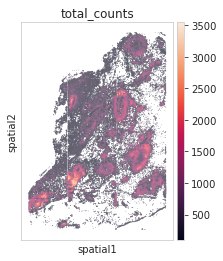

In [4]:
sc.pl.spatial(adata_st_rdn, color="total_counts",spot_size=320)

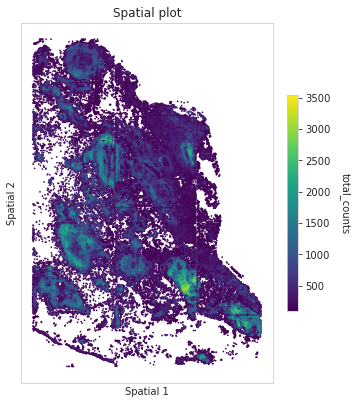

In [6]:
plot_spatial(adata_st_rdn)

# Atlas generation

The atlas will be generated from a gene set that runs through mutliple filtering steps:
1. spatially variable genes
2. overlap with marker genes for the tissue (provided by Anna&Tancredi)
3. overlap with gene list of the single-nuclei data with which the atlas shall be used for integration

This is necessary in order to create an atlas with maximum information for the later integration task.

In [ ]:
# sc.pp.highly_variable_genes(adata_st_rdn)#, min_mean=0.0125, max_mean=3, min_disp=0.5)

## Extract locations.txt and dge.txt from the anndata object

In [8]:
coord = adata_st_rdn.obsm['spatial']
coord_df = pd.DataFrame(data=coord, columns=['xcoord', 'ycoord'])
# coord_df.to_csv('output/TNBC_6w_fc51_4_coordinates.csv', index=False)

## filtering for spatially variable genes

In [25]:
sq.gr.spatial_neighbors(adata_st_rdn, coord_type='generic')
sq.gr.spatial_autocorr(adata_st_rdn, mode='moran')

In [26]:
adata_st_rdn.uns['moranI'] = adata_st_rdn.uns['moranI'].squeeze()
# you should save this version in the pckl file

### save anndata as pickle with Moran's calculation

### filter those with high confidence/low p-value

In [28]:
hgh_cnfdnc = adata_st_rdn.uns['moranI']['pval_norm_fdr_bh'] <= 0.01
len(hgh_cnfdnc[hgh_cnfdnc == True])
subsample_index = hgh_cnfdnc[hgh_cnfdnc == True].index

## Read in marker gene atlas

In [4]:
%%time
marker_dir = 'data' # symlinked to '/data/local/rajewsky/home/vschuma/NSTT/outputs/LabelTransfer/TNBC/'
marker_file = os.path.join(marker_dir,'6week_all_markers.csv')

all_marker_genes = pd.read_csv(marker_file, sep=',')
marker_genes = all_marker_genes['gene'].tolist()

CPU times: user 29.1 ms, sys: 12 ms, total: 41.2 ms
Wall time: 61.4 ms


## Read in single-nuclei gene list

In [7]:
# sn_gene_file = os.path.join(marker_dir,'TNBC_sn_integrated_dge.csv')
# sn_dge = sc.read(sn_gene_file).T

# STOP - csv should be saved as pckl file and read in by using pckl

sn_genes = sn_dge.var_names.to_list()

<class 'anndata._core.anndata.AnnData'>


AttributeError: 'AnnData' object has no attribute 'columns'

## Overlap

In [29]:
marker_set_to_subsample_from = list(set(marker_genes) & set(subsample_index) & set(sn_genes))
print(len(marker_set_to_subsample_from))

575

# generate the atlas

In [62]:
savepath = 'data/TNBC_atlas_OvrlbAtlasMarkerSnGenes.zip'
generate_atlas(marker_set_to_subsample_from,adata_st_rdn,samplesize=400,precision=100,savepath=savepath)

 subsampling 400 genes from a set of 575 genes
num loc w gene = 55478 
num loc w/o gene = 0
therefore gene marker cov = 1.0
100.0 % of the marker-locations are unique.
successfully saved atlas to data/TNBC_atlas_OvrlbAtlasMarkerSnGenes.zip


,Meg3,Slco2a1,Nrp2,Agps,Mef2c,Slc40a1,Emb,Evpl,Alcam,Ano1,...,Igf1,Cav1,Ednra,Pdgfra,Vcam1,Fcrls,Trps1,Bcl2l14,Pik3r1,Cxcl9
0,-0.161593,-0.056167,-0.045809,-0.048970,-0.017250,-0.014985,-0.084583,-0.021960,-0.032145,-0.096419,...,-0.150194,-0.178777,-0.022356,-0.143639,-0.031536,-0.047873,-0.143139,-0.018312,-0.108093,-0.013076
1,-0.276011,-0.138473,-0.103784,-0.132459,-0.042144,-0.038882,-0.183816,-0.057072,-0.087718,-0.211688,...,-0.265214,-0.293541,-0.051934,-0.258659,-0.069759,-0.100769,-0.254826,-0.053447,-0.223231,-0.030222
2,-0.376739,-0.244505,-0.212491,-0.238182,-0.100090,-0.094506,-0.284221,-0.138801,-0.196217,-0.321269,...,-0.369637,2.067810,-0.120783,-0.363083,-0.158729,-0.208911,-0.379031,-0.135230,-0.328816,-0.070135
3,3.958216,-0.163583,-0.121472,-0.157931,-0.049739,-0.046172,-0.209777,-0.067784,-0.104672,-0.229948,...,-0.282572,-0.312719,-0.060958,-0.276017,-0.081420,-0.116906,-0.275690,-0.064166,-0.240792,-0.035454
4,-0.188119,-0.072907,-0.057601,-0.065951,-0.022313,-0.019846,-0.104766,-0.029102,-0.043448,-0.128656,...,-0.179006,4.785232,-0.028371,-0.172452,-0.039310,-0.058632,-0.186789,-0.025458,-0.137653,-0.016563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55473,-0.186646,-0.071977,-0.056945,-0.065008,-0.022032,-0.019576,-0.103645,-0.028705,-0.042820,-0.126865,...,-0.177406,-0.212769,-0.028037,-0.170851,-0.038878,-0.058034,-0.184364,-0.025061,-0.136011,-0.016369
55474,-0.147593,-0.047332,-0.039586,-0.040008,-0.014578,-0.012420,-0.073931,-0.018191,-0.026179,-0.079405,...,4.865013,-0.159781,-0.019180,-0.128432,-0.027433,-0.042195,-0.120101,-0.014540,-0.092492,-0.011235
55475,-0.262479,-0.119873,-0.090682,-0.113592,-0.036519,-0.033482,-0.161391,-0.049137,-0.075159,-0.196887,...,-0.251155,-0.277983,-0.045250,-0.244600,-0.061121,-0.088815,-0.237873,-0.045507,-0.209006,-0.026347
55476,-0.162330,-0.056632,-0.046136,-0.049442,-0.017391,-0.015120,-0.085144,-0.022158,-0.032458,-0.097314,...,-0.150994,-0.179776,-0.022523,-0.144439,-0.031752,-0.048172,-0.144351,-0.018511,-0.108914,-0.013173


In [60]:
marker_cov = 1
unique_cov = 100.0
precision = 100

if marker_cov == 1.0 and int(unique_cov) >= precision:
    print("done")
else:
    print("not done")

done
